In [1]:
setwd("lnc_revision/gtex/new/")

In [ ]:
# Define number of regions per replicate and desired length
n=221959
len=2500

# Loop for 3 replicates
for rep in {1..3}; do
  awk -v len="$len" '
    BEGIN {
      OFS = "\t"
    }
    $1 ~ /^chr[0-9XY]+$/ {
      chr = $1
      start0 = $2
      end0 = $3
      gene = $4
      count = 1
      for (start = start0; start + len <= end0; start += len) {
        end = start + len
        print chr, start, end, gene "_" count
        count++
      }
    }
  ' gc47_coding_clean.bed | \
  shuf | \
  awk '!seen[$1,$2,$3]++' | \
  head -n "$n" | \
  sort -k1,1 -k2,2n > random_coding_genes_replicate${rep}.bed
done


# 10 kb
bedtools window -w 10000 -a /QRISdata/Q4386/all_cuTARs/all_cuTARs_refined_after_gencode47_clean_v5.bed  -b /QRISdata/Q4386/all_cuTARs/closest_gene/filtered_gc47/GTEX_eQTLs_17062023_SNPs.bed  | awk '{print $4"\t"$10}' | sed 's/\//\t/g' > 10kb/cuTARs_overlap
bedtools window -w 10000 -a random_coding_genes_replicate1.bed -b /QRISdata/Q4386/all_cuTARs/closest_gene/filtered_gc47/GTEX_eQTLs_17062023_SNPs.bed  | awk '{print $4"\t"$8}' | sed 's/\//\t/g' > 10kb/random1_overlap
bedtools window -w 10000 -a random_coding_genes_replicate2.bed -b /QRISdata/Q4386/all_cuTARs/closest_gene/filtered_gc47/GTEX_eQTLs_17062023_SNPs.bed  | awk '{print $4"\t"$8}' | sed 's/\//\t/g' > 10kb/random2_overlap
bedtools window -w 10000 -a random_coding_genes_replicate3.bed -b /QRISdata/Q4386/all_cuTARs/closest_gene/filtered_gc47/GTEX_eQTLs_17062023_SNPs.bed  | awk '{print $4"\t"$8}' | sed 's/\//\t/g' > 10kb/random3_overlap



In [2]:
library(tidyverse)

# Input files
cutar_file <- "rep/10kb/cuTARs_overlap"
random_files <- c("rep/10kb/random1_overlap", "rep/10kb/random2_overlap", "rep/10kb/random3_overlap")
total <- 221959  # Total cuTARs and random regions

# Function to count unique IDs per tissue
count_unique_per_tissue <- function(file) {
  read_tsv(file, col_names = c("ID", "SNP", "Gene", "Tissue")) %>%
    group_by(Tissue) %>%
    summarise(Count = n_distinct(ID)) %>%
    mutate(Percent = Count / total * 100)
}

# Process cuTAR file
cutar_counts <- count_unique_per_tissue(cutar_file) %>%
  rename(Percent_cutar = Percent)

# Process random files and aggregate all replicates into columns
random_counts <- map_dfr(random_files, ~count_unique_per_tissue(.x), .id = "Replicate") %>%
  select(Tissue, Percent, Replicate) %>%
  pivot_wider(names_from = Replicate, values_from = Percent, values_fill = 0, 
              names_prefix = "Percent_random")

# Combine into a single table
table <- as.data.frame(cutar_counts %>%
  select(Tissue, Percent_cutar) %>%
  left_join(random_counts, by = "Tissue") %>%
  replace_na(list(Percent_cutar = 0, Percent_random1 = 0, Percent_random2 = 0, Percent_random3 = 0)))

# Save and print
#write_csv(table, "tissue_enrichment_table.csv")
head(table)

Warning message:
“package ‘purrr’ was built under R version 4.4.1”
Warning message:
“package ‘stringr’ was built under R version 4.4.1”
Warning message:
“package ‘lubridate’ was built under R version 4.4.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 2839119 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): ID, SNP, Gene, Tissue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col

,Tissue,Percent_cutar,Percent_random1,Percent_random2,Percent_random3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Adipose_Subcutaneous,12.837506,9.843259,9.892368,10.077987
2,Adipose_Visceral_Omentum,10.442469,7.988863,8.072212,8.215031
3,Adrenal_Gland,6.992282,5.332516,5.313594,5.412711
4,Artery_Aorta,10.435711,8.095639,8.171329,8.282611
5,Artery_Coronary,5.792511,4.395857,4.443163,4.452174
6,Artery_Tibial,12.302272,9.917597,9.899576,9.943278


Warning message:
“package ‘reshape2’ was built under R version 4.4.1”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




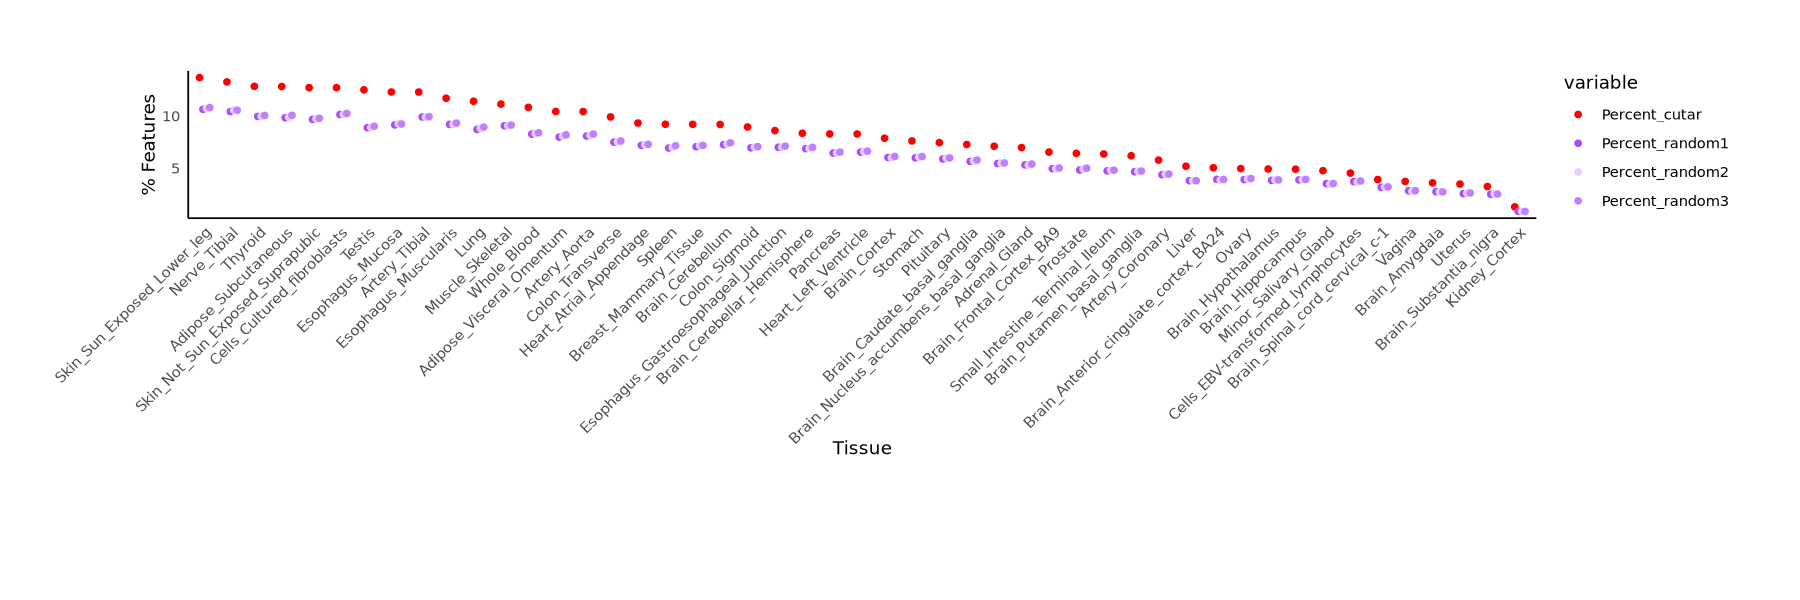

In [3]:
library(tidyverse)
library(reshape2)

# Assuming 'table' is the data from your previous step
d <- table

# Define custom colors
custom_colors <- c("Percent_cutar" = "red", 
                   "Percent_random1" = "#a64dff",
                   "Percent_random2" = "#e6ccff",
                   "Percent_random3" = "#bf80ff")

# Sort tissues by Percent_cutar (highest to lowest)
d <- d %>%
  arrange(desc(Percent_cutar))

# Reshape data to long format
df_long <- reshape2::melt(d, id.vars = "Tissue")

# Order Tissue factor based on sorted order
df_long$Tissue <- factor(df_long$Tissue, levels = unique(df_long$Tissue))

# Set plot dimensions
options(repr.plot.height = 5, repr.plot.width = 15)

# Plot
ggplot(df_long, aes(x = Tissue, y = value, color = variable)) +
  geom_point(position = position_dodge(width = 0.5)) +
  scale_color_manual(values = custom_colors) +
  labs(x = "Tissue", y = "% Features") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line.x = element_line(),
        axis.line.y = element_line(),
        plot.background = element_rect(fill = "white", color = NA),
        plot.margin = margin(1.5, 1.5, 3, 3, "cm")) +
  coord_cartesian(clip = "off")

# Save plot (uncomment to use)
ggsave("percent_features_with_eqtl_plot_grouped.pdf", width = 15, height = 5)

In [6]:
library(tidyverse)

total <- 219442  # Total cuTARs and random regions per tissue

# Calculate counts and ensure no NA/NaN
data <- d %>%
  mutate(
    Percent_cutar = replace_na(Percent_cutar, 0),
    Percent_random1 = replace_na(Percent_random1, 0),
    Percent_random2 = replace_na(Percent_random2, 0),
    Percent_random3 = replace_na(Percent_random3, 0),
    Count_cutar = round(Percent_cutar * total / 100),
    Count_random1 = round(Percent_random1 * total / 100),
    Count_random2 = round(Percent_random2 * total / 100),
    Count_random3 = round(Percent_random3 * total / 100),
    Count_random_mean = round(pmax(0, rowMeans(select(., starts_with("Count_random")), na.rm = TRUE)))
  )

# Aggregate counts across all tissues
total_cutar_overlapping <- sum(data$Count_cutar, na.rm = TRUE)
total_random_overlapping <- sum(data$Count_random_mean, na.rm = TRUE)

# Total possible regions
total_possible <- total * nrow(data)

# Non-overlapping counts
total_cutar_non_overlapping <- total_possible - total_cutar_overlapping
total_random_non_overlapping <- total_possible - total_random_overlapping

# Print counts for debugging
cat("Total cuTAR overlapping:", total_cutar_overlapping, "\n")
cat("Total cuTAR non-overlapping:", total_cutar_non_overlapping, "\n")
cat("Total random overlapping:", total_random_overlapping, "\n")
cat("Total random non-overlapping:", total_random_non_overlapping, "\n")

# Use a larger pseudo-count to avoid numerical issues
pseudo_count <- 10
total_cutar_overlapping <- total_cutar_overlapping + pseudo_count
total_random_overlapping <- total_random_overlapping + pseudo_count
total_cutar_non_overlapping <- total_cutar_non_overlapping + pseudo_count
total_random_non_overlapping <- total_random_non_overlapping + pseudo_count

# Perform Fisher's exact test
test_result <- fisher.test(matrix(c(total_cutar_overlapping, total_cutar_non_overlapping, 
                                    total_random_overlapping, total_random_non_overlapping), 2, 2))

# Extract p-value and odds ratio
overall_p_value <- test_result$p.value
overall_odds_ratio <- test_result$estimate

# Print results
cat("Overall P-value:", overall_p_value, "\n")
cat("Overall Odds Ratio:", overall_odds_ratio, "\n")

# Save results
results <- tibble(
  Comparison = "cuTARs vs Random",
  P_value = overall_p_value,
  Odds_Ratio = overall_odds_ratio
)
#write_csv(results, "overall_enrichment.csv")

Total cuTAR overlapping: 878218 
Total cuTAR non-overlapping: 9874440 
Total random overlapping: 0 
Total random non-overlapping: 10752658 
Overall P-value: 0 
Overall Odds Ratio: 4.5036e+15 


In [5]:
# Perform paired t-tests
test1 <- t.test(d$Percent_cutar, d$Percent_random1, paired = TRUE)
test2 <- t.test(d$Percent_cutar, d$Percent_random2, paired = TRUE)
test3 <- t.test(d$Percent_cutar, d$Percent_random3, paired = TRUE)

# Extract p-values
p_values <- c(test1$p.value, test2$p.value, test3$p.value)

# Adjust p-values using Benjamini-Hochberg
adjusted_p_values <- p.adjust(p_values, method = "BH")

# Create results dataframe
results <- data.frame(
  comparison = c("cuTARs vs Random1", "cuTARs vs Random2", "cuTARs vs Random3"),
  p_value = p_values,
  adjusted_p_value = adjusted_p_values
)

# Print and save results
print(results)
#write_csv(results, "ttest_enrichment_results.csv")

         comparison      p_value adjusted_p_value
1 cuTARs vs Random1 3.345138e-22     3.550033e-22
2 cuTARs vs Random2 2.630167e-22     3.550033e-22
3 cuTARs vs Random3 3.550033e-22     3.550033e-22


In [9]:
grep("Skin",df_long$Tissue)

[1]   1   5  50  54  99 103 148 152

In [10]:
df_long[c(1,5,50,54,99,103,148,152),]


,Tissue,variable,value
,<fct>,<fct>,<dbl>
1,Skin_Sun_Exposed_Lower_leg,Percent_cutar,13.689916
5,Skin_Not_Sun_Exposed_Suprapubic,Percent_cutar,12.723972
50,Skin_Sun_Exposed_Lower_leg,Percent_random1,10.649264
54,Skin_Not_Sun_Exposed_Suprapubic,Percent_random1,9.691880
99,Skin_Sun_Exposed_Lower_leg,Percent_random2,10.740272
103,Skin_Not_Sun_Exposed_Suprapubic,Percent_random2,9.744142
148,Skin_Sun_Exposed_Lower_leg,Percent_random3,10.812808
152,Skin_Not_Sun_Exposed_Suprapubic,Percent_random3,9.790096


In [13]:
grep("Esophag",df_long$Tissue)
df_long[c(8,10,22,57,59,71,106,108,120,155,157,169),]


[1]   8  10  22  57  59  71 106 108 120 155 157 169

,Tissue,variable,value
,<fct>,<fct>,<dbl>
8,Esophagus_Mucosa,Percent_cutar,12.308129
10,Esophagus_Muscularis,Percent_cutar,11.708919
22,Esophagus_Gastroesophageal_Junction,Percent_cutar,8.616907
57,Esophagus_Mucosa,Percent_random1,9.159800
59,Esophagus_Muscularis,Percent_random1,9.206655
71,Esophagus_Gastroesophageal_Junction,Percent_random1,7.020666
106,Esophagus_Mucosa,Percent_random2,9.262071
108,Esophagus_Muscularis,Percent_random2,9.204853
120,Esophagus_Gastroesophageal_Junction,Percent_random2,7.030127
